In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

# Translate CSV to SWF

In [26]:
# Read the required columns along with 'QUEUE_NAME' from the CSV file
columns_to_read = ['QUEUED_TIMESTAMP', 'RUNTIME_SECONDS', 'WALLTIME_SECONDS', 'NODES_REQUESTED', 'QUEUE_NAME', 'QUEUED_WAIT_SECONDS', 'COBALT_JOBID']
df = pd.read_csv('ANL-ALCF-DJC-THETA_20180101_20181231.csv', usecols=columns_to_read)

# Filter rows where QUEUE_NAME is either 'default' or 'backfill'
df = df[df['QUEUE_NAME'].isin(['default'])]
df.sort_values(by='COBALT_JOBID', ascending=True, inplace=True)



# Convert the 'QUEUED_TIMESTAMP' column to datetime objects
df['QUEUED_TIMESTAMP'] = pd.to_datetime(df['QUEUED_TIMESTAMP'])

first_queued_timestamp = df.iloc[0][df.columns.get_loc('QUEUED_TIMESTAMP')]




# Initialize an empty list to store the formatted rows
formatted_rows = []

counter = 0
# Iterate through the DataFrame to format each row
for index, row in df.iterrows():
    # Calculate the job submit time in seconds
    job_submit_time = (row['QUEUED_TIMESTAMP'] - first_queued_timestamp).total_seconds()
    
    # Format the row according to the specifications
    formatted_row = [
        counter,
        int(job_submit_time),
        row['QUEUED_WAIT_SECONDS'],
        row['RUNTIME_SECONDS'],
        row['NODES_REQUESTED'],
        -1, -1,
        row['NODES_REQUESTED'],
        row['WALLTIME_SECONDS'],
        -1, 0, -1, -1, -1, -1, -1, -1, -1, 0
    ]
    formatted_rows.append(formatted_row)
    
    counter +=1

# Convert the list of formatted rows to a DataFrame
formatted_df = pd.DataFrame(formatted_rows, dtype=int)

# Write the DataFrame to a new file named 'theta.swf'
output_file_path = 'theta_2018.swf'
formatted_df.to_csv(output_file_path, header=False, index=False, sep=' ')

header_lines = [
    "; UnixStartTime: 1514764835",
    "; MaxNodes: 4360",
    "; MaxProcs: 4360"
]

# Read the existing content of the file
with open(output_file_path, 'r') as f:
    existing_content = f.read()

# Combine the header lines and existing content
new_content = '\n'.join(header_lines) + '\n' + existing_content

# Write the new content back to the file
with open(output_file_path, 'w') as f:
    f.write(new_content)


# Translate SWF to CSV

In [32]:
# Assume the path to the 'temp.swf' file (replace this with the actual path in your local environment)
# path = 'cori.swf'
path = './swf/theta_2018.swf'
# Initialize an empty list to store the selected columns from each row
selected_columns = []

# Column names for the resulting DataFrame
column_names = ['id', 'queued_time', 'wait_time', 'runtime', 'node_requested', 'node_used', 'walltime']

# Read the file line by line
with open(path, 'r') as file:
    for line in file:
        # Skip lines that start with ';'
        if line.startswith(';'):
            continue

        # Split the line into elements
        elements = line.strip().split()

        # Select columns with indices [0, 1, 2, 3, 4, 7, 8]
        selected_row = [elements[i] for i in [0, 1, 2, 3, 4, 7, 8]]
        selected_columns.append(selected_row)

# Create a DataFrame from the selected columns
df_selected = pd.DataFrame(selected_columns, columns=column_names)

# Convert the data to appropriate types (all to int in this case)
df_selected = df_selected.astype(int)

# Export the DataFrame to a CSV file
csv_file_path = 'theta_2018.csv'
df_selected.to_csv(csv_file_path, index=False)

# Data Analysis of trace

In [30]:
path = "/Users/zhongzheng/Desktop/CQSim/data/InputFiles/cori.swf"
rows_to_print = []
# Read the file line by line
with open(path, 'r') as file:
    for line in file:
        # Skip lines that start with ';'
        if line.startswith(';'):
            continue

        # Split the line into elements
        elements = line.strip().split()

        # Check if the fourth element (index 3) is greater than 4360
        if int(elements[4]) > 4360:
            rows_to_print.append(line.strip())


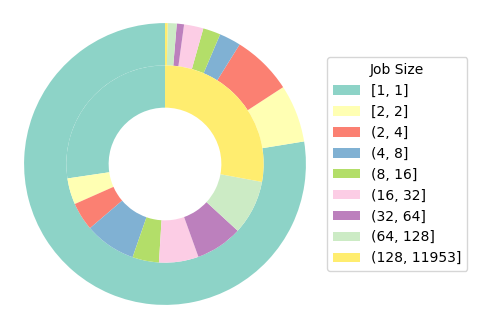

In [23]:
# Assume the path to the 'cori_2018.csv' file 
cori_2018 = './csv/cori_2018.csv'

# Read the CSV file into a DataFrame
df_cori_2018 = pd.read_csv(cori_2018)

# Extract the 'node_used' column
node_used_series = df_cori_2018['node_used']

# Count the number of jobs with exactly 1 or 2 nodes
count_1_node = (node_used_series == 1).sum()
count_2_nodes = (node_used_series == 2).sum()

# Total number of jobs
total_jobs = len(node_used_series)

# Define the bins for node count distribution for other cases
bins = [2, 4, 8, 16, 32, 64, 128, 11953]

# Count the distribution of the nodes within the specified bins, excluding 1 and 2
node_distribution = pd.cut(node_used_series[node_used_series > 2], bins=bins, right=True, include_lowest=False).value_counts().sort_index()


# Combine the exact counts and the binned counts
node_distribution_dict = {'[1, 1]': count_1_node, '[2, 2]': count_2_nodes, **node_distribution.to_dict()}

# Calculate the percentage for each bin
node_distribution_percentage = {k: (v / total_jobs) * 100 for k, v in node_distribution_dict.items()}

# Combine the counts and percentages
node_distribution_with_percentage = {k: {'count': v, 'percentage': node_distribution_percentage[k]} for k, v in node_distribution_dict.items()}



####### core hour percentage ########

# Extract the 'walltime' column
walltime_series = df_cori_2018['walltime']

# Calculate node count multiplied by walltime for each job
node_walltime_product = node_used_series * walltime_series

# # Initialize a dictionary to store the aggregated results for each bin
aggregated_node_walltime = {}

# # Aggregate for the cases where node count is exactly 1 or 2
aggregated_node_walltime['[1, 1]'] = node_walltime_product[node_used_series == 1].sum()
aggregated_node_walltime['[2, 2]'] = node_walltime_product[node_used_series == 2].sum()

for interval, count in node_distribution.items():
    interval_str = str(interval)  # Convert the Interval object to its string representation
    mask = (node_used_series >= interval.left) & (node_used_series < interval.right)
    aggregated_node_walltime[interval_str] = node_walltime_product[mask].sum()


# Special condition for the last bin (128, 11953]
mask = (node_used_series > 128) & (node_used_series <= 11953)
aggregated_node_walltime['(128, 11953]'] = node_walltime_product[mask].sum()

if '[128, 11953)' in aggregated_node_walltime and '(128, 11953]' in aggregated_node_walltime:
    combined_value = aggregated_node_walltime['[128, 11953)'] + aggregated_node_walltime['(128, 11953]']
    aggregated_node_walltime['[128, 11953)'] = combined_value
    del aggregated_node_walltime['(128, 11953]']

# Total aggregated metric
total_aggregated = sum(aggregated_node_walltime.values())

# Calculate the percentage for each bin
aggregated_percentage = {k: (v / total_aggregated) * 100 for k, v in aggregated_node_walltime.items()}

# Combine the counts, percentages, and aggregated metrics
core_hour_cori = {}
for k, v in node_distribution_with_percentage.items():
    core_hour_cori[k] = {
        'count': v['count'],
        'percentage': v['percentage'],
        'aggregated_metric': aggregated_node_walltime.get(str(k), 0),  # Use string keys
        'aggregated_percentage': aggregated_percentage.get(str(k), 0)  # Use string keys
    }
    
    
    
# Extract just the counts from the final_results dictionary
counts = [v['count'] for v in core_hour_cori.values()]

# Extract the aggregated metrics percentages from the final_results dictionary
aggregated_metrics_percentage = [v['aggregated_percentage'] for v in core_hour_cori.values()]

# Extract the bin labels
labels = list(core_hour_cori.keys())

# Define the colors (You can modify this to your liking)
colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))

# Create the outer pie chart for node distribution
plt.figure(figsize=(4, 4))
wedges1, _ = plt.pie(counts, radius=1, startangle=90, wedgeprops=dict(width=0.3), colors=colors)

# Create the inner pie chart for aggregated metrics percentages
wedges2, _ = plt.pie(aggregated_metrics_percentage, radius=0.7, startangle=90, wedgeprops=dict(width=0.3), colors=colors)

# Create a legend
plt.legend(wedges1, labels, title="Job Size", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()


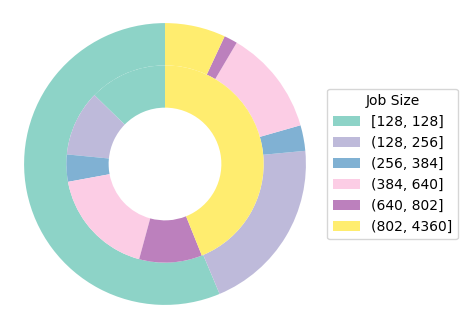

In [69]:
# Assume the path to the 'theta_2018.csv' file 
theta_2018 = './csv/theta_2018.csv'

# Read the CSV file into a DataFrame
df_theta_2018 = pd.read_csv(theta_2018)

# Extract the 'node_used' column
node_used_series = df_theta_2018['node_used']

# Count the number of jobs with exactly 128 nodes
count_128_node = (node_used_series == 128).sum()

# Total number of jobs
total_jobs = len(node_used_series)

# Define the bins for node count distribution for other cases
bins = [128, 256, 384, 640, 802, 4360]

# Count the distribution of the nodes within the specified bins, excluding 128
node_distribution = pd.cut(node_used_series[node_used_series > 128], bins=bins, right=True, include_lowest=False).value_counts().sort_index()

# Combine the exact count and the binned counts
node_distribution_dict = {'[128, 128]': count_128_node, **node_distribution.to_dict()}

# Calculate the percentage for each bin
node_distribution_percentage = {k: (v / total_jobs) * 100 for k, v in node_distribution_dict.items()}

# Combine the counts and percentages
node_distribution_with_percentage = {k: {'count': v, 'percentage': node_distribution_percentage[k]} for k, v in node_distribution_dict.items()}

####### core hour percentage ########

# Extract the 'walltime' column
walltime_series = df_theta_2018['walltime']

# Calculate node count multiplied by walltime for each job
node_walltime_product = node_used_series * walltime_series

# Initialize a dictionary to store the aggregated results for each bin
aggregated_node_walltime = {}

# Aggregate for the case where node count is exactly 128
aggregated_node_walltime['[128, 128]'] = node_walltime_product[node_used_series == 128].sum()

# Aggregate for other bins
for interval, count in node_distribution.items():
    interval_str = str(interval)  # Convert the Interval object to its string representation
    mask = (node_used_series > interval.left) & (node_used_series <= interval.right)
    aggregated_node_walltime[interval_str] = node_walltime_product[mask].sum()

# Total aggregated metric
total_aggregated = sum(aggregated_node_walltime.values())

# Calculate the percentage for each bin
aggregated_percentage = {k: (v / total_aggregated) * 100 for k, v in aggregated_node_walltime.items()}

# Combine the counts, percentages, and aggregated metrics
core_hour_theta = {}
for k, v in node_distribution_with_percentage.items():
    core_hour_theta[k] = {
        'count': v['count'],
        'percentage': v['percentage'],
        'aggregated_metric': aggregated_node_walltime.get(str(k), 0),
        'aggregated_percentage': aggregated_percentage.get(str(k), 0)
    }

# Extract the counts and aggregated metrics percentages for the pie chart
counts = [v['count'] for v in core_hour_theta.values()]
aggregated_metrics_percentage = [v['aggregated_percentage'] for v in core_hour_theta.values()]
labels = list(core_hour_theta.keys())
colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))

# Create the pie charts
plt.figure(figsize=(4, 4))
wedges1, _ = plt.pie(counts, radius=1, startangle=90, wedgeprops=dict(width=0.3), colors=colors)
wedges2, _ = plt.pie(aggregated_metrics_percentage, radius=0.7, startangle=90, wedgeprops=dict(width=0.3), colors=colors)
plt.legend(wedges1, labels, title="Job Size", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.show()


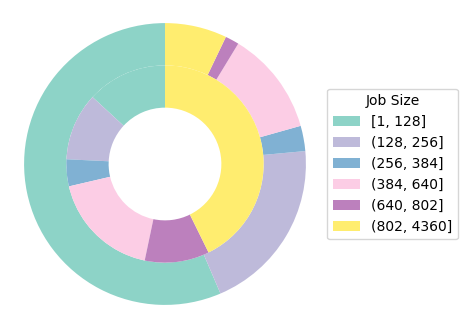

In [2]:
# Assume the path to the 'theta_2018.csv' file 
theta_2018 = './csv/theta_cori_2018.csv'

# Read the CSV file into a DataFrame
df_theta_2018 = pd.read_csv(theta_2018)

# Extract the 'node_used' column
node_used_series = df_theta_2018['node_used']

# Count the number of jobs with exactly 128 nodes
count_128_node = (node_used_series == 128).sum()

# Total number of jobs
total_jobs = len(node_used_series)

# Define the bins for node count distribution for other cases
bins = [128, 256, 384, 640, 802, 4360]

# Count the distribution of the nodes within the specified bins, excluding 128
node_distribution = pd.cut(node_used_series[node_used_series > 128], bins=bins, right=True, include_lowest=False).value_counts().sort_index()

# Combine the exact count and the binned counts
node_distribution_dict = {'[1, 128]': count_128_node, **node_distribution.to_dict()}

# Calculate the percentage for each bin
node_distribution_percentage = {k: (v / total_jobs) * 100 for k, v in node_distribution_dict.items()}

# Combine the counts and percentages
node_distribution_with_percentage = {k: {'count': v, 'percentage': node_distribution_percentage[k]} for k, v in node_distribution_dict.items()}

####### core hour percentage ########

# Extract the 'walltime' column
walltime_series = df_theta_2018['walltime']

# Calculate node count multiplied by walltime for each job
node_walltime_product = node_used_series * walltime_series

# Initialize a dictionary to store the aggregated results for each bin
aggregated_node_walltime = {}

# Aggregate for the case where node count is exactly 128
aggregated_node_walltime['[1, 128]'] = node_walltime_product[node_used_series == 128].sum()

# Aggregate for other bins
for interval, count in node_distribution.items():
    interval_str = str(interval)  # Convert the Interval object to its string representation
    mask = (node_used_series > interval.left) & (node_used_series <= interval.right)
    aggregated_node_walltime[interval_str] = node_walltime_product[mask].sum()

# Total aggregated metric
total_aggregated = sum(aggregated_node_walltime.values())

# Calculate the percentage for each bin
aggregated_percentage = {k: (v / total_aggregated) * 100 for k, v in aggregated_node_walltime.items()}

# Combine the counts, percentages, and aggregated metrics
core_hour_theta = {}
for k, v in node_distribution_with_percentage.items():
    core_hour_theta[k] = {
        'count': v['count'],
        'percentage': v['percentage'],
        'aggregated_metric': aggregated_node_walltime.get(str(k), 0),
        'aggregated_percentage': aggregated_percentage.get(str(k), 0)
    }

# Extract the counts and aggregated metrics percentages for the pie chart
counts = [v['count'] for v in core_hour_theta.values()]
aggregated_metrics_percentage = [v['aggregated_percentage'] for v in core_hour_theta.values()]
labels = list(core_hour_theta.keys())
colors = plt.cm.Set3(np.linspace(0, 1, len(labels)))

# Create the pie charts
plt.figure(figsize=(4, 4))
wedges1, _ = plt.pie(counts, radius=1, startangle=90, wedgeprops=dict(width=0.3), colors=colors)
wedges2, _ = plt.pie(aggregated_metrics_percentage, radius=0.7, startangle=90, wedgeprops=dict(width=0.3), colors=colors)
plt.legend(wedges1, labels, title="Job Size", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.axis('equal')
plt.show()


In [60]:
import pandas as pd
import numpy as np
import math

# Load DataFrames
theta_df = pd.read_csv('./csv/theta_2018.csv')
cori_df = pd.read_csv('./csv/cori_2018.csv')

# Number of rows to be replaced
n = len(theta_df) // 2  # half of the rows in theta_2018.csv

# Get a list of bins from core_hour dictionary
bins = list(core_hour_cori.keys())

# Calculate how many rows to select from each bin in cori
rows_to_select_from_bin = {bin: int(core_hour_cori[bin]['percentage'] * n / 100) for bin in bins}

# Initialize a list to store the sampled rows from cori
cori_sampled_rows = []


import re

# Sample rows from each bin in cori
for bin_obj, count in rows_to_select_from_bin.items():
    bin_str = str(bin_obj)  # Convert bin object to string
    # parse the interval string to get the left and right bounds
    left, right = map(int, re.findall(r'\d+', bin_str))
    is_left_closed = bin_str[0] == '['
    is_right_closed = bin_str[-1] == ']'
    
    if is_left_closed:
        mask = (cori_df['node_used'] >= left)
    else:
        mask = (cori_df['node_used'] > left)
        
    if is_right_closed:
        mask &= (cori_df['node_used'] <= right)
    else:
        mask &= (cori_df['node_used'] < right)
    
    available_rows = cori_df[mask]
    if count > len(available_rows):
        sampled_rows = available_rows
    else:
        sampled_rows = available_rows.sample(n=count, random_state=1)
        
    cori_sampled_rows.extend(sampled_rows.to_dict('records'))



# Sample n rows from theta to be replaced
theta_sampled_indices = theta_df.sample(n=n, random_state=1).index

# Replace the sampled rows in theta with the sampled rows from cori
for i, idx in enumerate(theta_sampled_indices):
    if i >= len(cori_sampled_rows):  # if i is out of the range of cori_sampled_rows
        break  # break the loop
    
    cori_row = cori_sampled_rows[i]
    theta_df.at[idx, 'node_requested'] = math.ceil(max(cori_row['node_requested'] / 3, 1))
    theta_df.at[idx, 'node_used'] = math.ceil(max(cori_row['node_used'] / 3, 1))
    theta_df.at[idx, 'walltime'] = cori_row['walltime']


# Save the modified DataFrame to a new CSV file
theta_df.to_csv('theta_cori_2018.csv', index=False)


In [61]:
# translate the combined csv to swf

# Read the required columns along with 'QUEUE_NAME' from the CSV file

df = pd.read_csv('./csv/theta_cori_2018.csv')


# Initialize an empty list to store the formatted rows
formatted_rows = []

counter = 0
# Iterate through the DataFrame to format each row
for index, row in df.iterrows():
    
    # Format the row according to the specifications
    formatted_row = [
        counter,
        row['queued_time'],
        row['wait_time'],
        row['runtime'],
        row['node_requested'],
        -1, -1,
        row['node_requested'],
        row['walltime'],
        -1, 0, -1, -1, -1, -1, -1, -1, -1, 0
    ]
    formatted_rows.append(formatted_row)
    
    counter +=1

# Convert the list of formatted rows to a DataFrame
formatted_df = pd.DataFrame(formatted_rows, dtype=int)

# Write the DataFrame to a new file named 'theta.swf'
output_file_path = 'theta_cori_2018.swf'
formatted_df.to_csv(output_file_path, header=False, index=False, sep=' ')

header_lines = [
    "; UnixStartTime: 1514764835",
    "; MaxNodes: 4360",
    "; MaxProcs: 4360"
]

# Read the existing content of the file
with open(output_file_path, 'r') as f:
    existing_content = f.read()

# Combine the header lines and existing content
new_content = '\n'.join(header_lines) + '\n' + existing_content

# Write the new content back to the file
with open(output_file_path, 'w') as f:
    f.write(new_content)